<a href="https://colab.research.google.com/github/catastropiyush/LLMon/blob/main/Phi_3_Mini_4K_Instruct_Unsloth_2x_faster_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

We'll use the `Phi-3` format for conversational finetunes. We use the [Open Assistant dataset](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style.

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

* We support Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes etc
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* [**NEW**] We make Llama-3 15 trillion tokens **2x faster**! See our [Llama-3 notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Mistral patching. Transformers = 4.43.4.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/145 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
!pip install bertviz

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [5]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

KeyError: 'token_type_ids'

In [6]:
from bertviz import model_view
from transformers import AutoTokenizer
import torch

In [7]:
sentence_a = "The cat sat on"
sentence_b = "the mat."

# Tokenize the input
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', padding=True, truncation=True)

In [8]:
# Make sure the input is on the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Get the model outputs
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attention = outputs.attentions

AssertionError: 

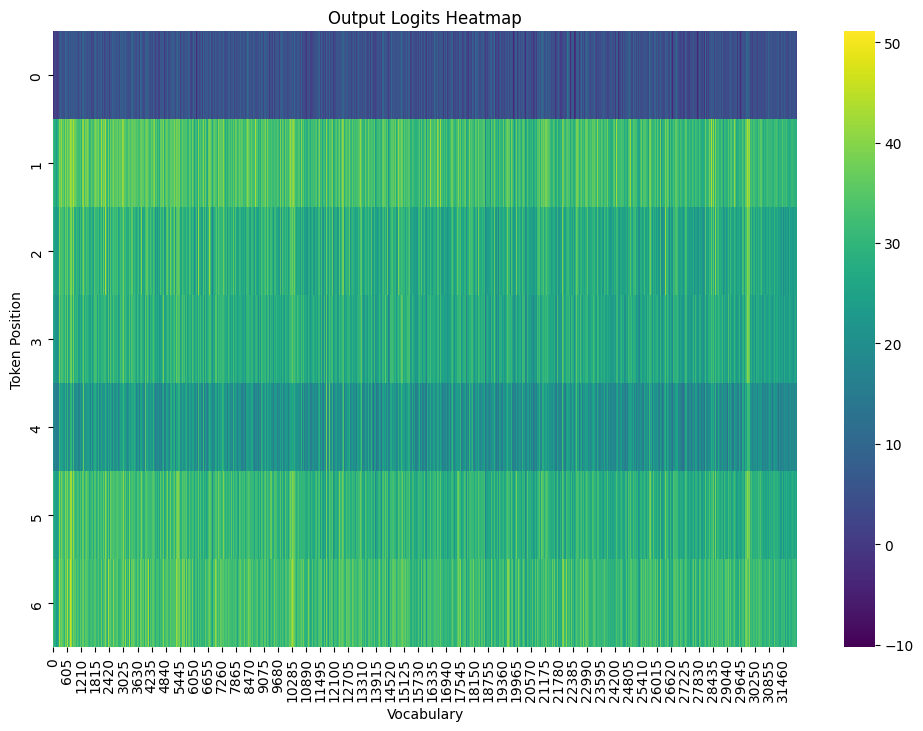

In [9]:
sentence = "The cat sat on the mat."

# Tokenize the input
inputs = tokenizer(sentence, return_tensors='pt')

# Make sure the input is on the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Get the model outputs
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Visualize logits
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(logits[0].cpu().numpy(), cmap='viridis')
plt.title('Output Logits Heatmap')
plt.xlabel('Vocabulary')
plt.ylabel('Token Position')
plt.show()

In [10]:
def compute_token_importance(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        original_output = model(**inputs).logits

    importance_scores = []
    for i in range(inputs['input_ids'].shape[1]):
        masked_input = inputs['input_ids'].clone()
        masked_input[0, i] = tokenizer.mask_token_id
        with torch.no_grad():
            masked_output = model(masked_input).logits

        importance = torch.norm(original_output - masked_output).item()
        importance_scores.append(importance)

    return importance_scores

importance_scores = compute_token_importance(model, tokenizer, sentence)
tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

plt.figure(figsize=(12, 6))
plt.bar(tokens, importance_scores)
plt.title('Token Importance')
plt.xlabel('Tokens')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TypeError: can't assign a NoneType to a torch.cuda.LongTensor

In [11]:
pip install smplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 19.0 MB/s eta 0:00:00


In [13]:
import smplotlib

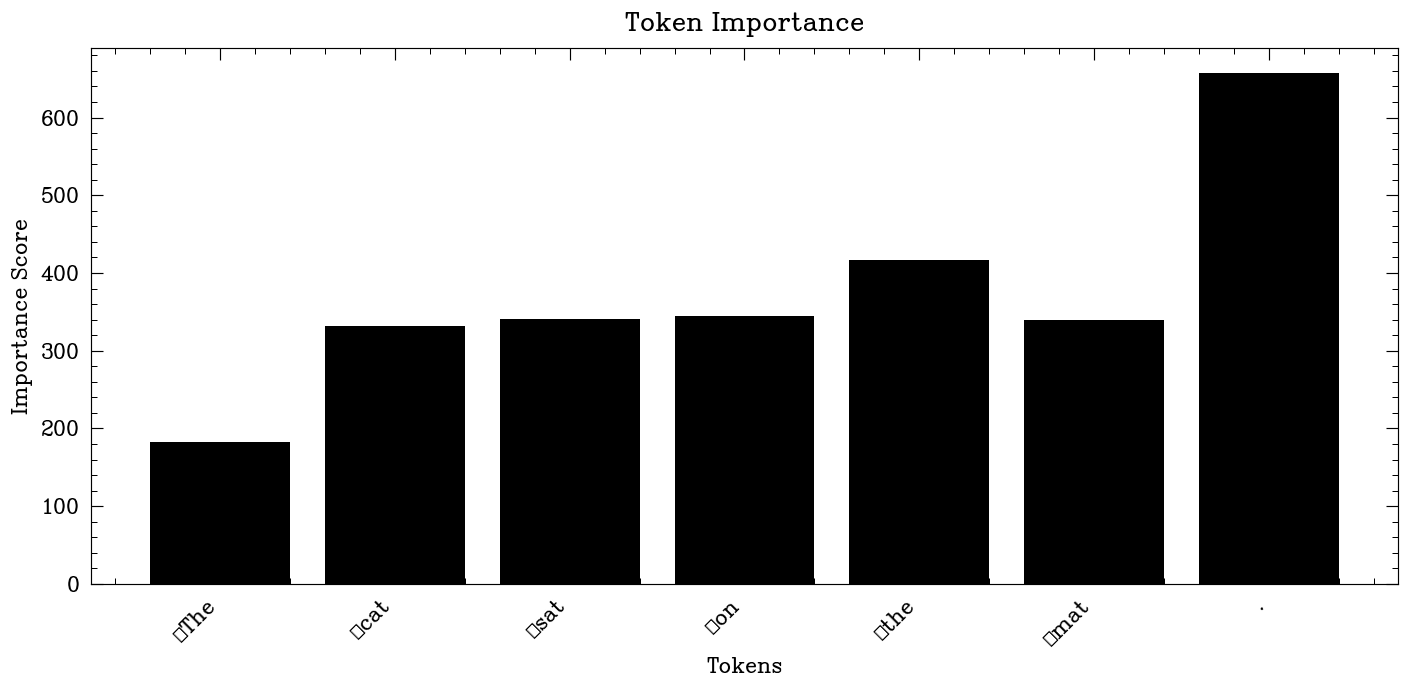

In [14]:
def compute_token_importance(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        original_output = model(**inputs).logits

    importance_scores = []
    for i in range(inputs['input_ids'].shape[1]):
        # Instead of masking, we'll remove the token
        masked_input = inputs['input_ids'].clone()
        masked_input = torch.cat([masked_input[:, :i], masked_input[:, i+1:]], dim=1)

        # Adjust attention mask if it exists
        if 'attention_mask' in inputs:
            masked_attention = inputs['attention_mask'].clone()
            masked_attention = torch.cat([masked_attention[:, :i], masked_attention[:, i+1:]], dim=1)
        else:
            masked_attention = None

        with torch.no_grad():
            masked_output = model(masked_input, attention_mask=masked_attention).logits

        # Compare the outputs at the final token position
        importance = torch.norm(original_output[:, -1] - masked_output[:, -1]).item()
        importance_scores.append(importance)

    return importance_scores

# Use the function
sentence = "The cat sat on the mat."
importance_scores = compute_token_importance(model, tokenizer, sentence)
tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(tokens, importance_scores)
plt.title('Token Importance')
plt.xlabel('Tokens')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

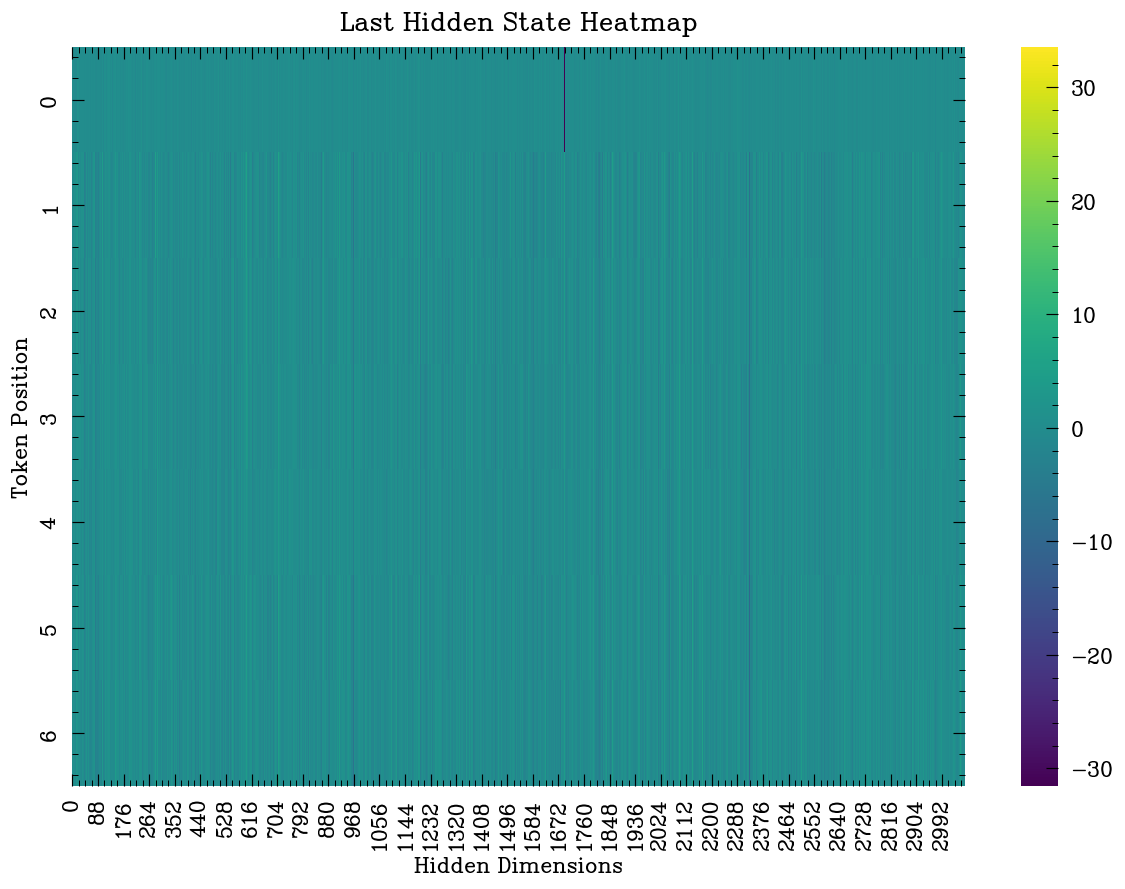

In [15]:
# Assuming the model outputs hidden states
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

hidden_states = outputs.hidden_states

# Visualize the last hidden state
last_hidden_state = hidden_states[-1][0]  # Shape: [sequence_length, hidden_size]

plt.figure(figsize=(12, 8))
sns.heatmap(last_hidden_state.cpu().numpy(), cmap='viridis')
plt.title('Last Hidden State Heatmap')
plt.xlabel('Hidden Dimensions')
plt.ylabel('Token Position')
plt.show()

In [16]:
!pip install torchviz

import torch
from torchviz import make_dot

# Create a sample input
sample_input = tokenizer("This is a sample input", return_tensors="pt")
sample_input = {k: v.to(model.device) for k, v in sample_input.items()}

# Get the model output
output = model(**sample_input)

# Create a visual graph of the model
dot = make_dot(output.logits, params=dict(model.named_parameters()))
dot.render("model_structure", format="png")

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=fd27a492baa59ed98d76660ca21c0863457c40811b5a8ebf0f9717b493871e08
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.632482 to fit


'model_structure.png'

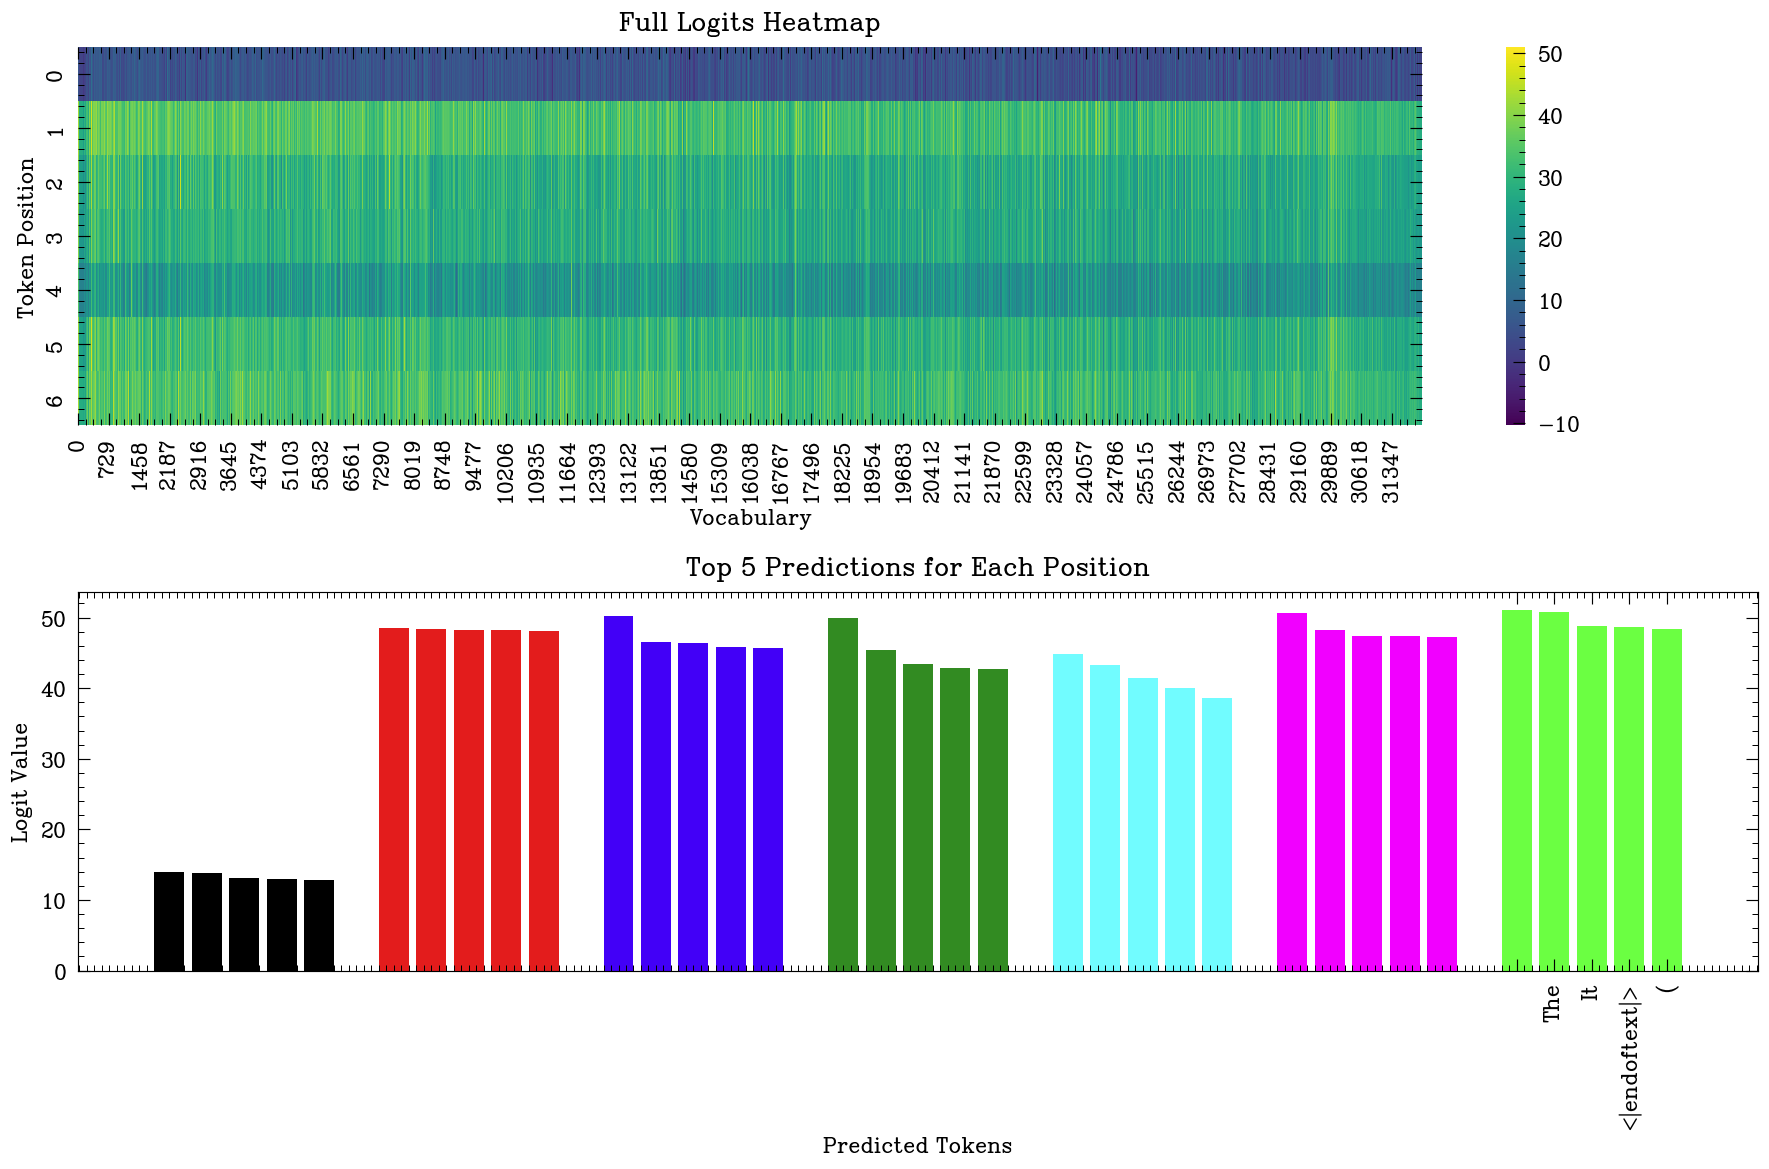

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_logits(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get top 5 predictions for each position
    top_k = 5
    top_logits = np.argsort(-logits, axis=1)[:, :top_k]
    top_tokens = [[tokenizer.decode(idx) for idx in pos] for pos in top_logits]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Heatmap of all logits
    sns.heatmap(logits, ax=ax1, cmap='viridis')
    ax1.set_title('Full Logits Heatmap')
    ax1.set_xlabel('Vocabulary')
    ax1.set_ylabel('Token Position')

    # Bar plot of top 5 predictions for each position
    for i, (token, preds) in enumerate(zip(tokens, top_tokens)):
        ax2.bar(np.arange(top_k) + i*6, logits[i, top_logits[i]], align='center')
        ax2.set_xticks(np.arange(top_k) + i*6)
        ax2.set_xticklabels(preds, rotation=90)
    ax2.set_title('Top 5 Predictions for Each Position')
    ax2.set_xlabel('Predicted Tokens')
    ax2.set_ylabel('Logit Value')

    plt.tight_layout()
    plt.show()

sentence = "The cat sat on the mat."
visualize_logits(model, tokenizer, sentence)

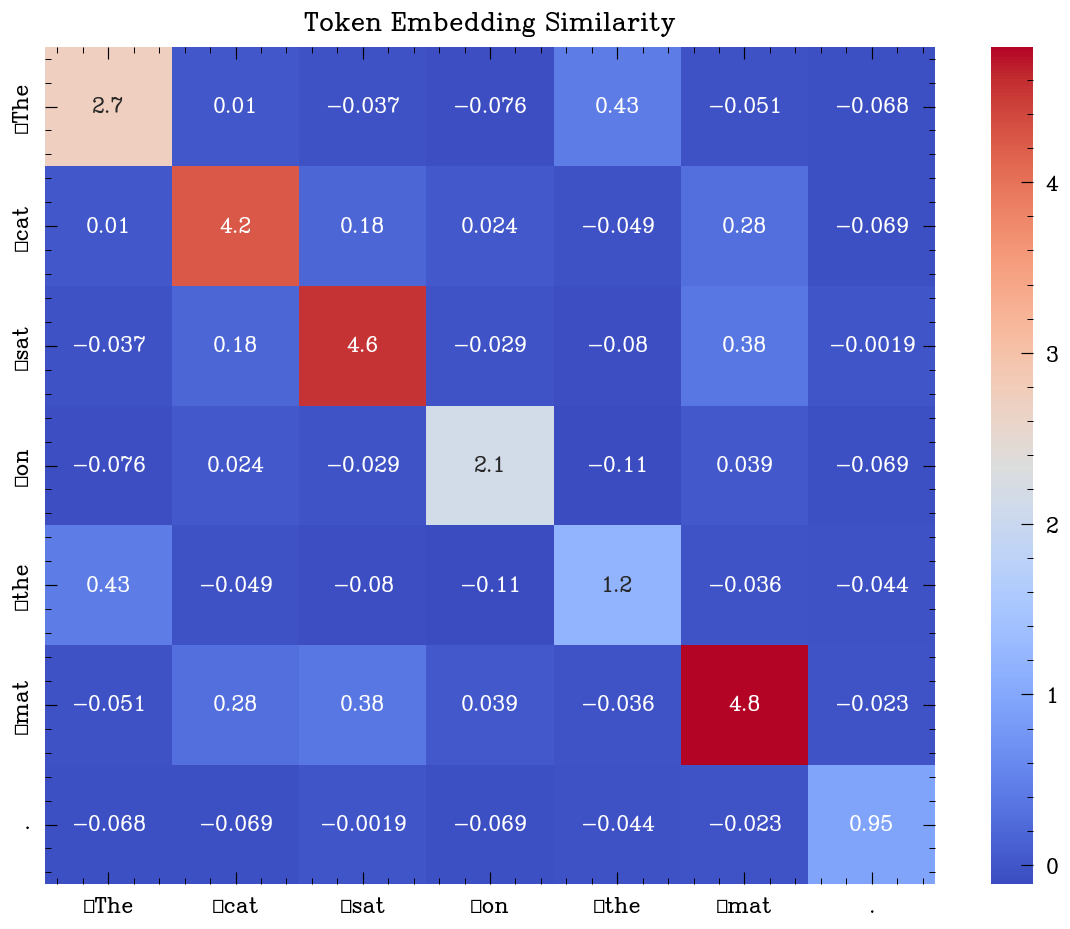

In [18]:
def visualize_token_similarity(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        embeddings = model.get_input_embeddings()(inputs['input_ids'][0]).cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    similarity = np.inner(embeddings, embeddings)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity, annot=True, cmap='coolwarm', xticklabels=tokens, yticklabels=tokens)
    plt.title('Token Embedding Similarity')
    plt.tight_layout()
    plt.show()

visualize_token_similarity(model, tokenizer, sentence)

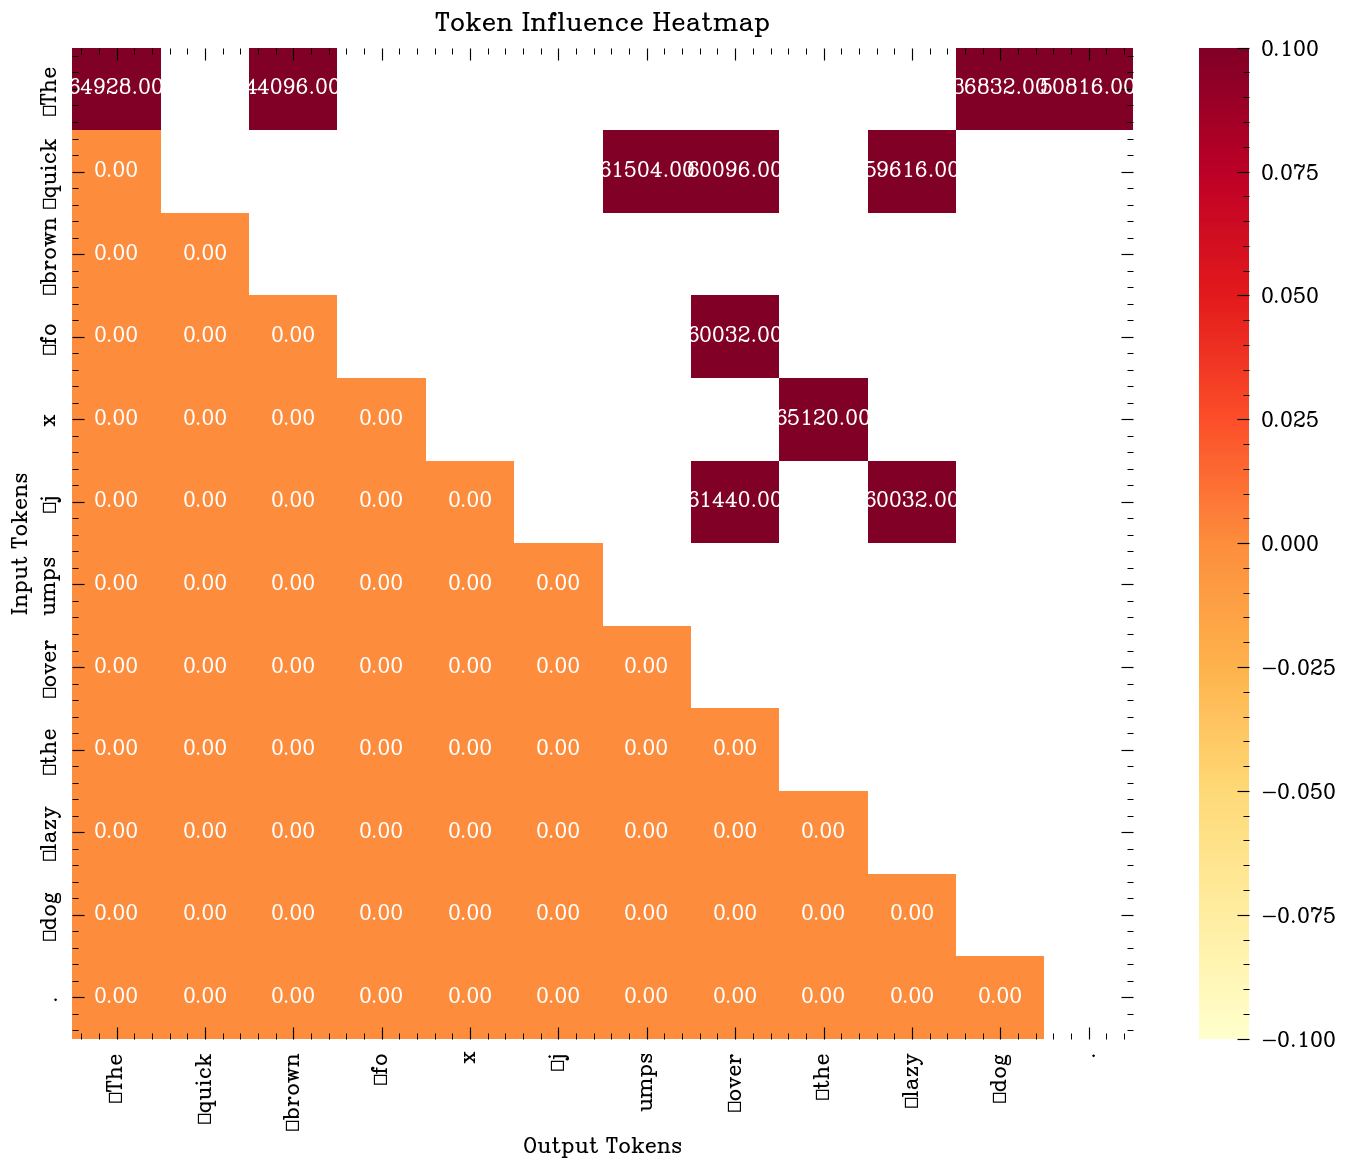

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def token_influence_heatmap(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_len = inputs['input_ids'].shape[1]

    influence_matrix = torch.zeros((input_len, input_len))

    for i in range(input_len):
        masked_input = inputs['input_ids'].clone()
        masked_input[0, i] = tokenizer.pad_token_id

        with torch.no_grad():
            original_output = model(**inputs).logits
            masked_output = model(masked_input).logits

        difference = (original_output - masked_output).abs().sum(dim=-1)
        influence_matrix[i] = difference[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(12, 10))
    sns.heatmap(influence_matrix.cpu().numpy(), annot=True, fmt='.2f', cmap='YlOrRd', xticklabels=tokens, yticklabels=tokens)
    plt.title('Token Influence Heatmap')
    plt.xlabel('Output Tokens')
    plt.ylabel('Input Tokens')
    plt.tight_layout()
    plt.show()

sentence = "The quick brown fox jumps over the lazy dog."
token_influence_heatmap(model, tokenizer, sentence)

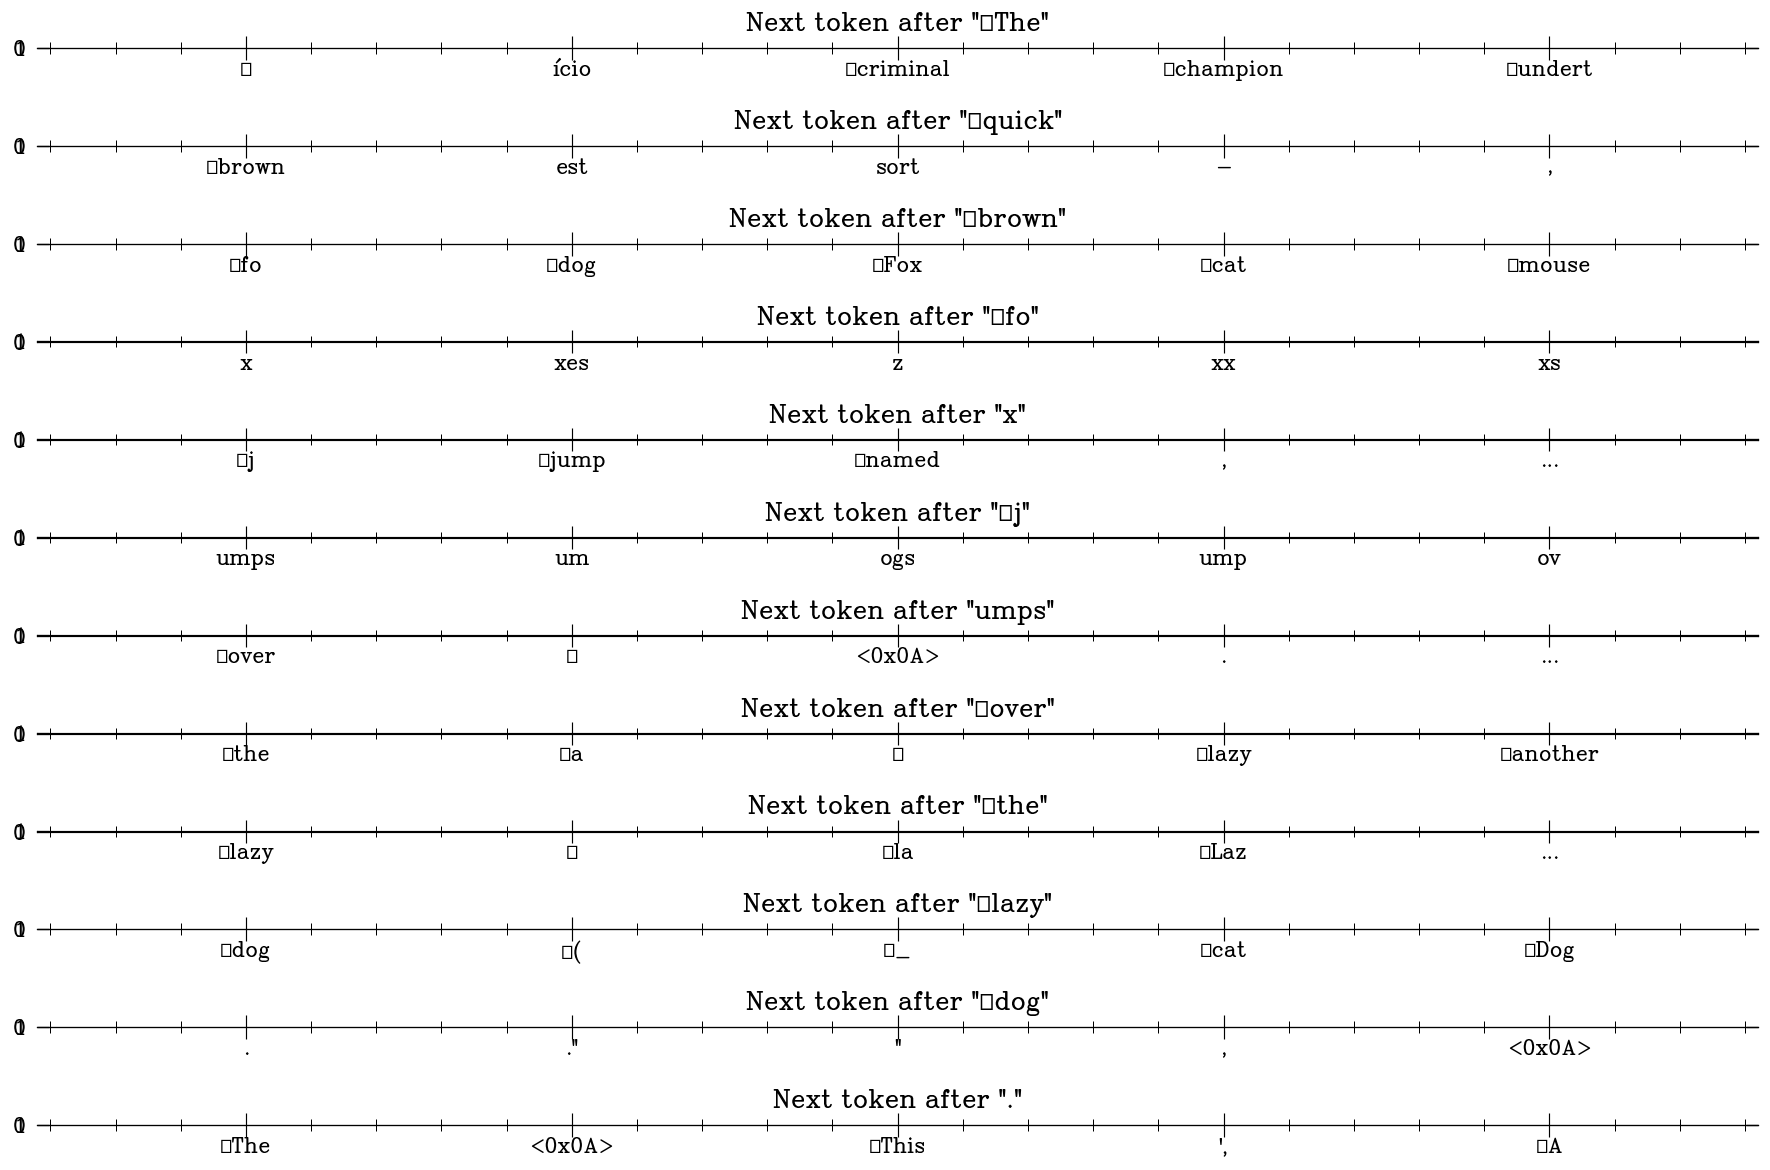

In [22]:
def next_token_prediction_distribution(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(15, 10))
    for i in range(len(tokens)):
        plt.subplot(len(tokens), 1, i+1)
        top_probs, top_indices = torch.topk(probs[0, i], k=5)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
        plt.bar(top_tokens, top_probs.cpu().numpy())
        plt.title(f'Next token after "{tokens[i]}"')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

next_token_prediction_distribution(model, tokenizer, sentence)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

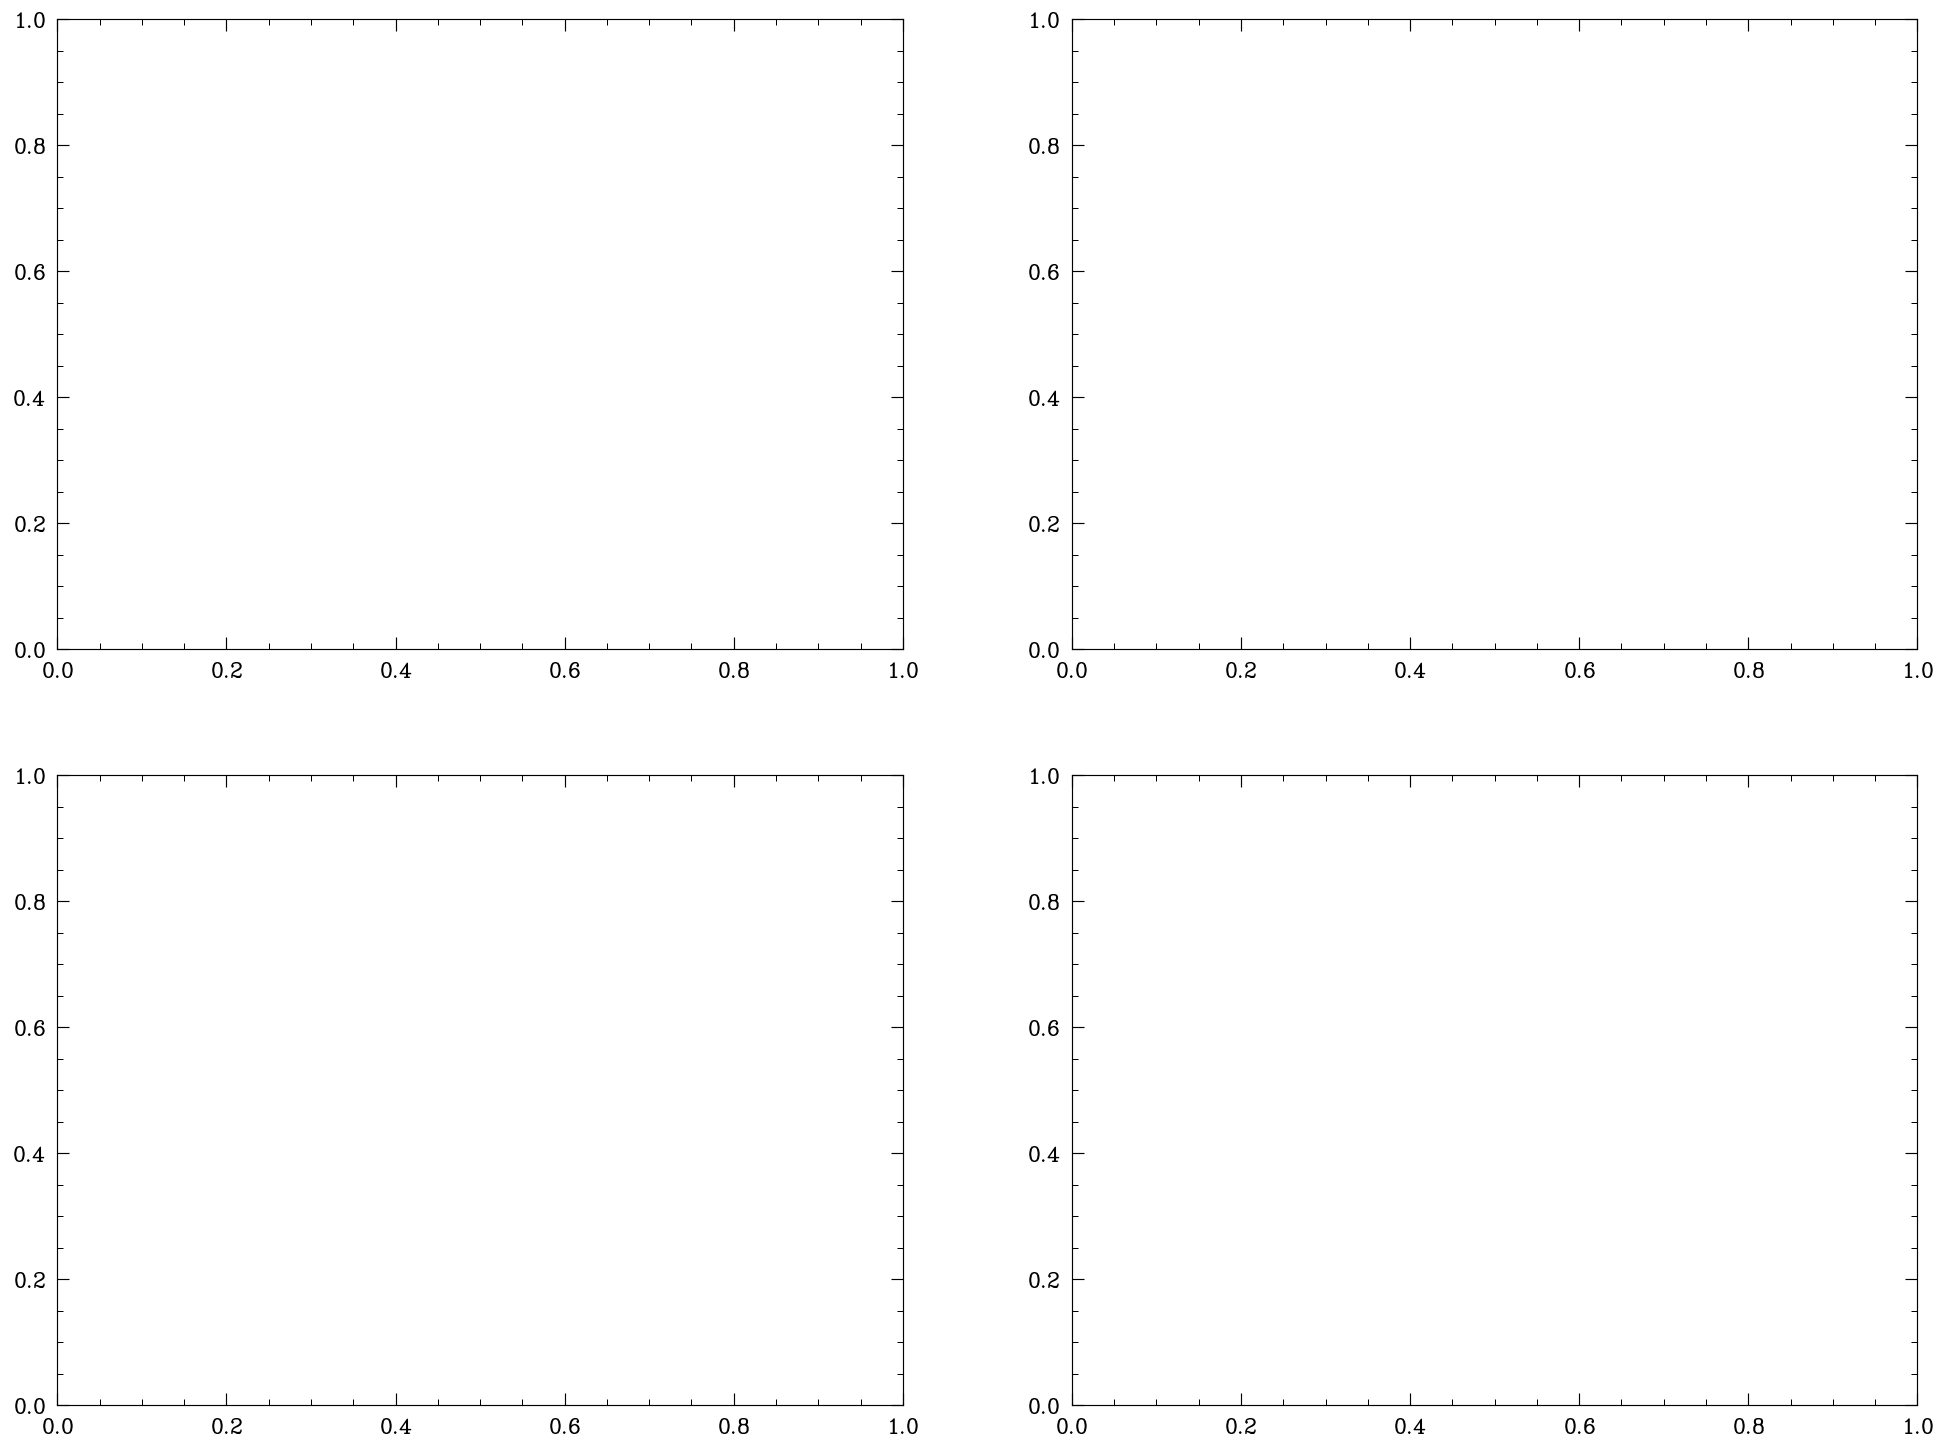

In [23]:
def neuron_activation_patterns(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()

    layers_to_plot = [0, len(hidden_states)//3, 2*len(hidden_states)//3, -1]

    for i, layer in enumerate(layers_to_plot):
        activations = hidden_states[layer][0].cpu().numpy()
        sns.heatmap(activations.T, ax=axes[i], cmap='coolwarm', center=0)
        axes[i].set_title(f'Layer {layer} Neuron Activations')
        axes[i].set_xlabel('Token Position')
        axes[i].set_ylabel('Neuron Index')
        axes[i].set_xticks(range(len(tokens)))
        axes[i].set_xticklabels(tokens, rotation=90)

    plt.tight_layout()
    plt.show()

neuron_activation_patterns(model, tokenizer, sentence)

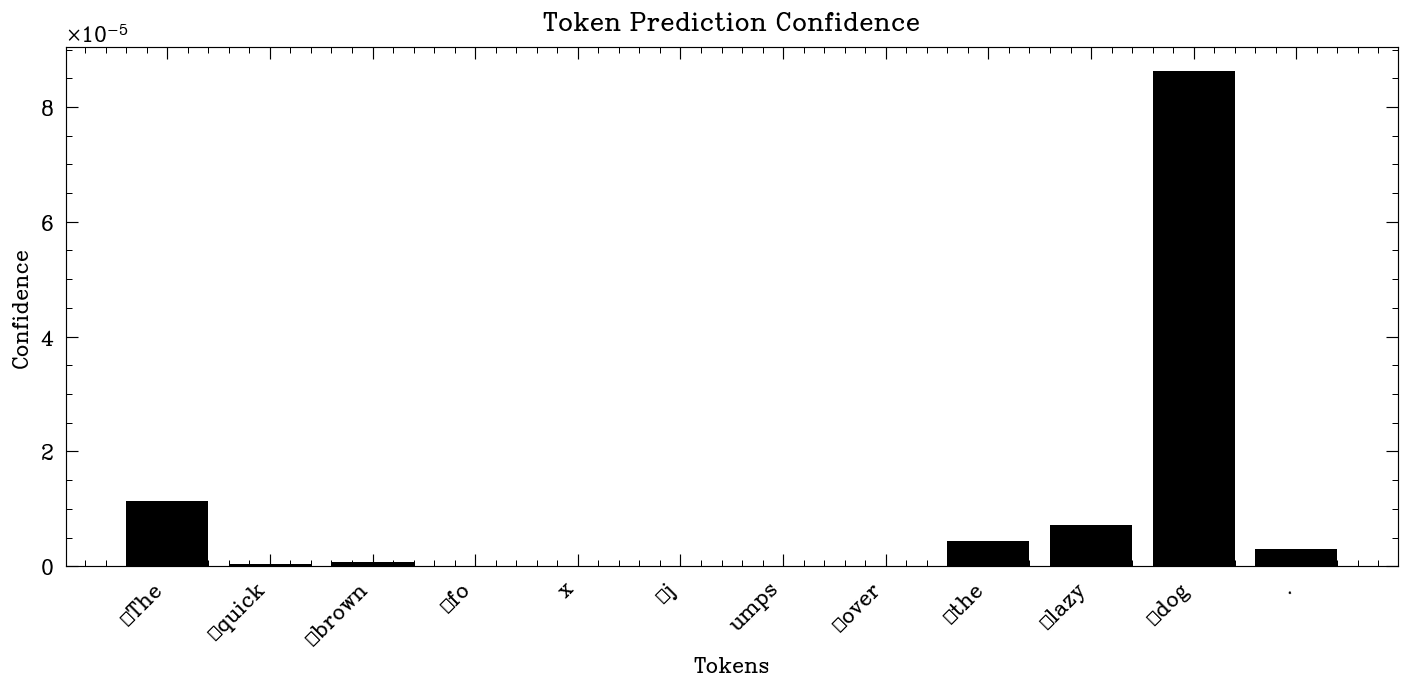

In [24]:
def token_prediction_confidence(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    confidence = probs[0, range(len(tokens)), inputs['input_ids'][0]]

    plt.figure(figsize=(12, 6))
    plt.bar(tokens, confidence.cpu().numpy())
    plt.title('Token Prediction Confidence')
    plt.xlabel('Tokens')
    plt.ylabel('Confidence')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

token_prediction_confidence(model, tokenizer, sentence)

In [25]:
def attention_rollout(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = torch.stack(outputs.attentions).squeeze(1)
    num_layers, num_heads, seq_len, _ = attentions.shape

    attention_rollout = torch.eye(seq_len).to(model.device)
    for layer in range(num_layers):
        layer_attention = attentions[layer].mean(dim=0)
        attention_rollout = torch.matmul(layer_attention, attention_rollout)

    return attention_rollout.cpu().numpy()

def visualize_attention_rollout(model, tokenizer, sentence):
    rollout = attention_rollout(model, tokenizer, sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

    plt.figure(figsize=(10, 8))
    sns.heatmap(rollout, annot=True, cmap='YlOrRd', xticklabels=tokens, yticklabels=tokens)
    plt.title('Attention Rollout')
    plt.xlabel('To')
    plt.ylabel('From')
    plt.tight_layout()
    plt.show()

visualize_attention_rollout(model, tokenizer, sentence)

AssertionError: 

In [26]:
!pip install shap

import shap

def compute_shap_values(model, tokenizer, sentence, num_samples=100):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_ids = inputs['input_ids'][0]

    def f(x):
        return model(x).logits[:, -1, :].cpu().detach().numpy()

    explainer = shap.Explainer(f, input_ids, algorithm="permutation")
    shap_values = explainer(input_ids, max_evals=2 * num_samples + 1)

    return shap_values.values[0]

def visualize_shap_values(model, tokenizer, sentence):
    shap_values = compute_shap_values(model, tokenizer, sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

    plt.figure(figsize=(12, 4))
    shap.plots.bar(shap_values, feature_names=tokens, show=False)
    plt.title('SHAP Values')
    plt.tight_layout()
    plt.show()

visualize_shap_values(model, tokenizer, sentence)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 28.9 MB/s eta 0:00:00


IndexError: tuple index out of range

In [27]:
def integrated_gradients(model, tokenizer, sentence, steps=50):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_ids = inputs['input_ids']
    baseline = torch.zeros_like(input_ids)

    alphas = torch.linspace(0, 1, steps).to(model.device)
    interpolated = torch.stack([baseline + alpha * (input_ids - baseline) for alpha in alphas])

    interpolated.requires_grad_()

    outputs = model(interpolated)
    loss = outputs.logits[:, -1, :].sum(dim=-1)

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated)[0]

    avg_grads = torch.mean(gradients, dim=0)
    integrated_grads = (input_ids - baseline) * avg_grads

    return integrated_grads.sum(dim=-1)[0].cpu().detach().numpy()

def visualize_integrated_gradients(model, tokenizer, sentence):
    attributions = integrated_gradients(model, tokenizer, sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

    plt.figure(figsize=(12, 4))
    sns.barplot(x=tokens, y=attributions)
    plt.title('Integrated Gradients')
    plt.xlabel('Tokens')
    plt.ylabel('Attribution Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

visualize_integrated_gradients(model, tokenizer, sentence)

ValueError: too many values to unpack (expected 2)

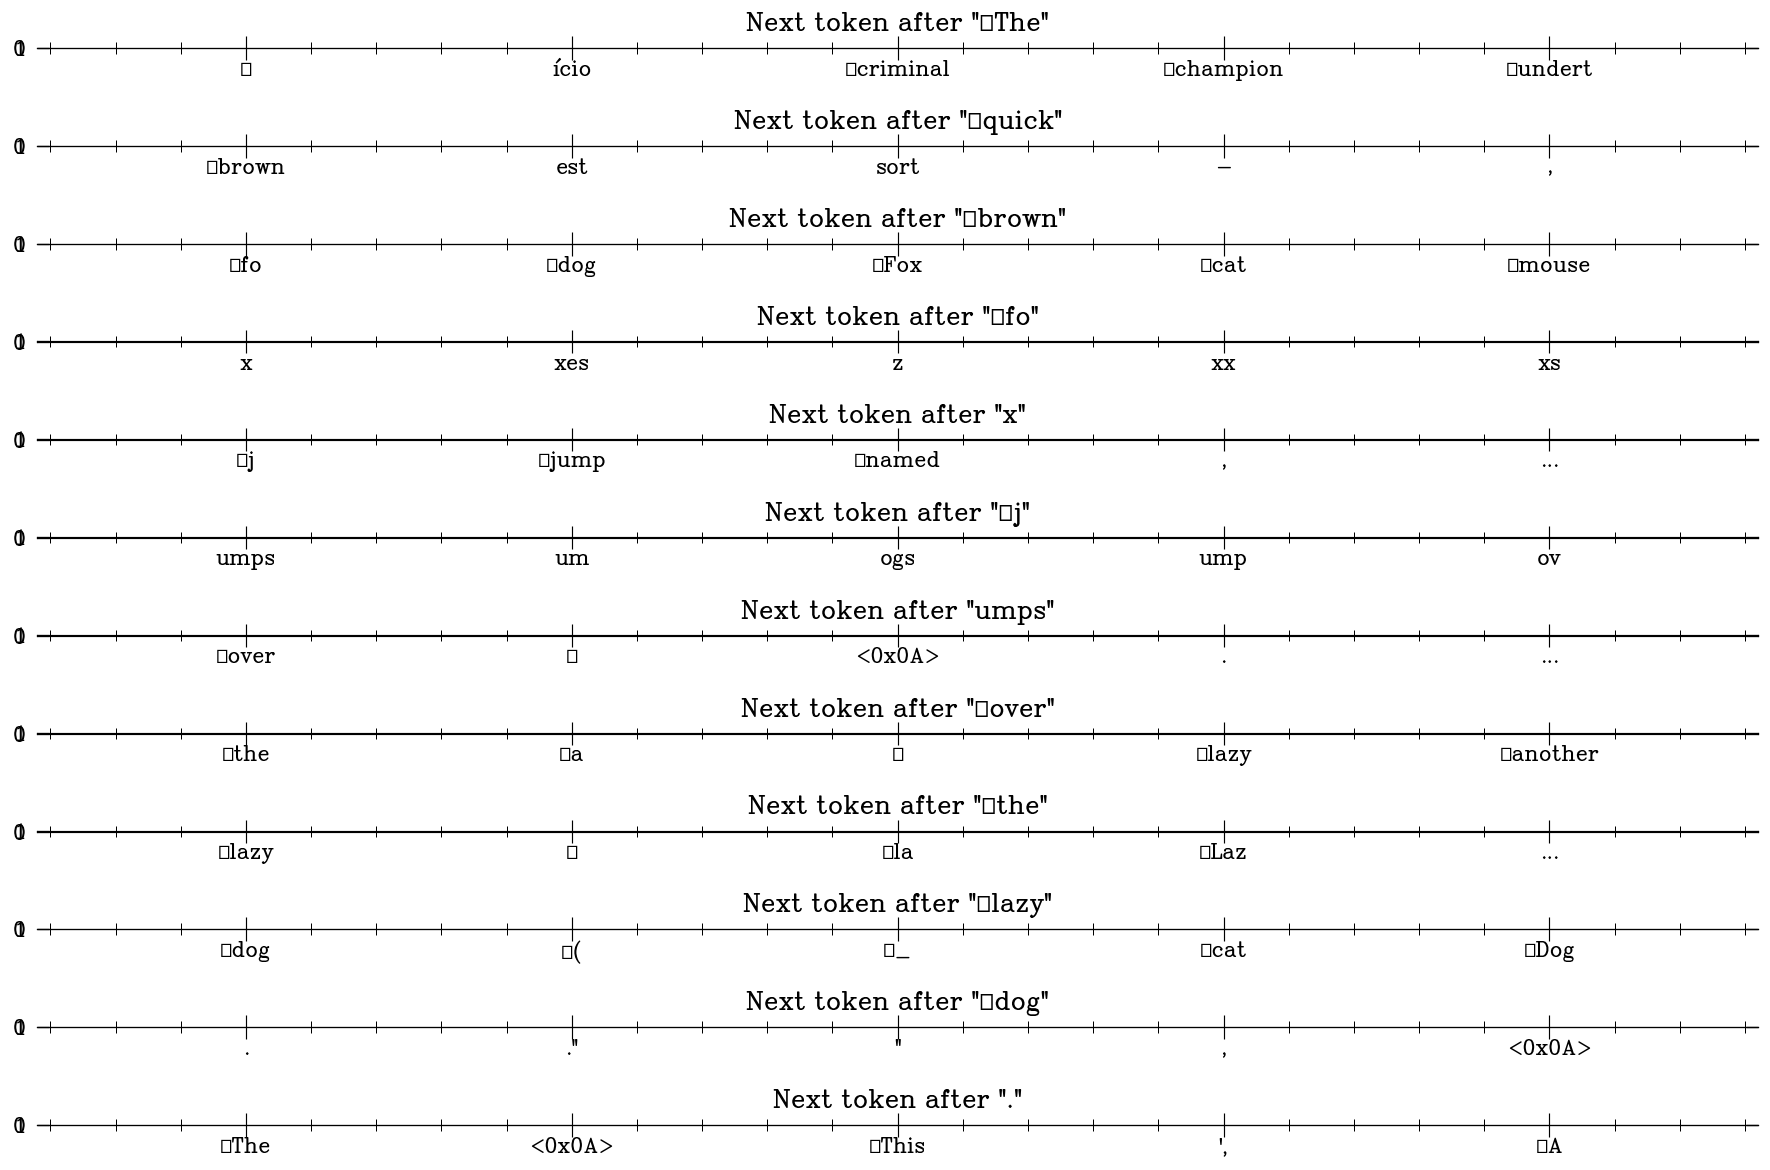

In [28]:
def visualize_next_token_predictions(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(15, 10))
    for i in range(len(tokens)):
        plt.subplot(len(tokens), 1, i+1)
        top_probs, top_indices = torch.topk(probs[0, i], k=5)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
        plt.bar(top_tokens, top_probs.cpu().numpy())
        plt.title(f'Next token after "{tokens[i]}"')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

visualize_next_token_predictions(model, tokenizer, sentence)

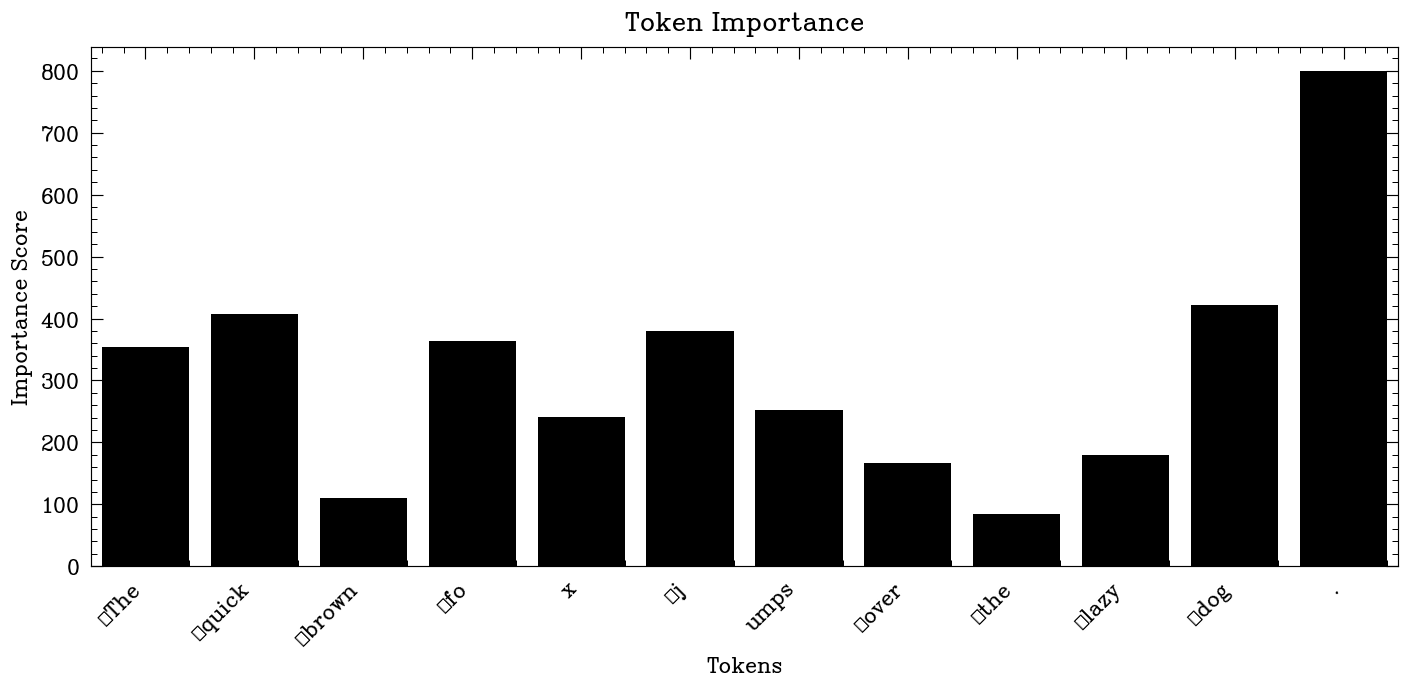

AttributeError: 'NoneType' object has no attribute 'squeeze'

In [32]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from bertviz import head_view

def compute_token_importance(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        original_output = model(**inputs).logits

    importance_scores = []
    for i in range(inputs['input_ids'].shape[1]):
        # Remove the token instead of masking
        masked_input = inputs['input_ids'].clone()
        masked_input = torch.cat([masked_input[:, :i], masked_input[:, i+1:]], dim=1)

        with torch.no_grad():
            masked_output = model(masked_input).logits

        importance = torch.norm(original_output[:, -1] - masked_output[:, -1]).item()
        importance_scores.append(importance)

    return importance_scores

def visualize_token_importance(model, tokenizer, sentence):
    importance_scores = compute_token_importance(model, tokenizer, sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=tokens, y=importance_scores)
    plt.title('Token Importance')
    plt.xlabel('Tokens')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def get_attention(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Hook to extract attention
    attn = []
    def hook(module, input, output):
        attn.append(output[1])  # Extract the attention weights

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if 'attn' in name or 'attention' in name:
            hooks.append(module.register_forward_hook(hook))

    with torch.no_grad():
        _ = model(**inputs)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return attn

def visualize_attention(model, tokenizer, sentence):
    attentions = get_attention(model, tokenizer, sentence)
    formatted_attentions = [attn.squeeze(0).detach().cpu().numpy() for attn in attentions]
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))
    head_view(formatted_attentions, tokens)

# Example sentence
sentence = "The quick brown fox jumps over the lazy dog."

# Visualize token importance
visualize_token_importance(model, tokenizer, sentence)

# Visualize attention using BertViz
visualize_attention(model, tokenizer, sentence)


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load pipeline
classifier = pipeline('text-classification', model=model, tokenizer=model)

# Example sentence
sentence = "The quick brown fox jumps over the lazy dog."

# Get model output
outputs = classifier(sentence, return_all_scores=True)[0]

# Extract scores and labels
scores = [output['score'] for output in outputs]
labels = [output['label'] for output in outputs]

# Plot scores
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=scores)
plt.title('Text Classification Scores')
plt.xlabel('Labels')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


AttributeError: 'MistralForCausalLM' object has no attribute 'pad_token_id'

In [35]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

def interpret_sentence(model, tokenizer, sentence):
    model.eval()
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    def forward_pass(inputs):
        outputs = model(**inputs)
        return outputs.logits

    ig = IntegratedGradients(forward_pass)
    attributions, _ = ig.attribute(inputs['input_ids'], target=0, return_convergence_delta=False)

    return attributions.squeeze(0).sum(dim=-1).cpu().detach().numpy(), tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().cpu().numpy())

# Example sentence
sentence = "The quick brown fox jumps over the lazy dog."

# Get Integrated Gradients attributions
attributions, tokens = interpret_sentence(model, tokenizer, sentence)

# Plot attributions
plt.figure(figsize=(12, 6))
sns.barplot(x=tokens, y=attributions)
plt.title('Token Importance via Integrated Gradients')
plt.xlabel('Tokens')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'captum'

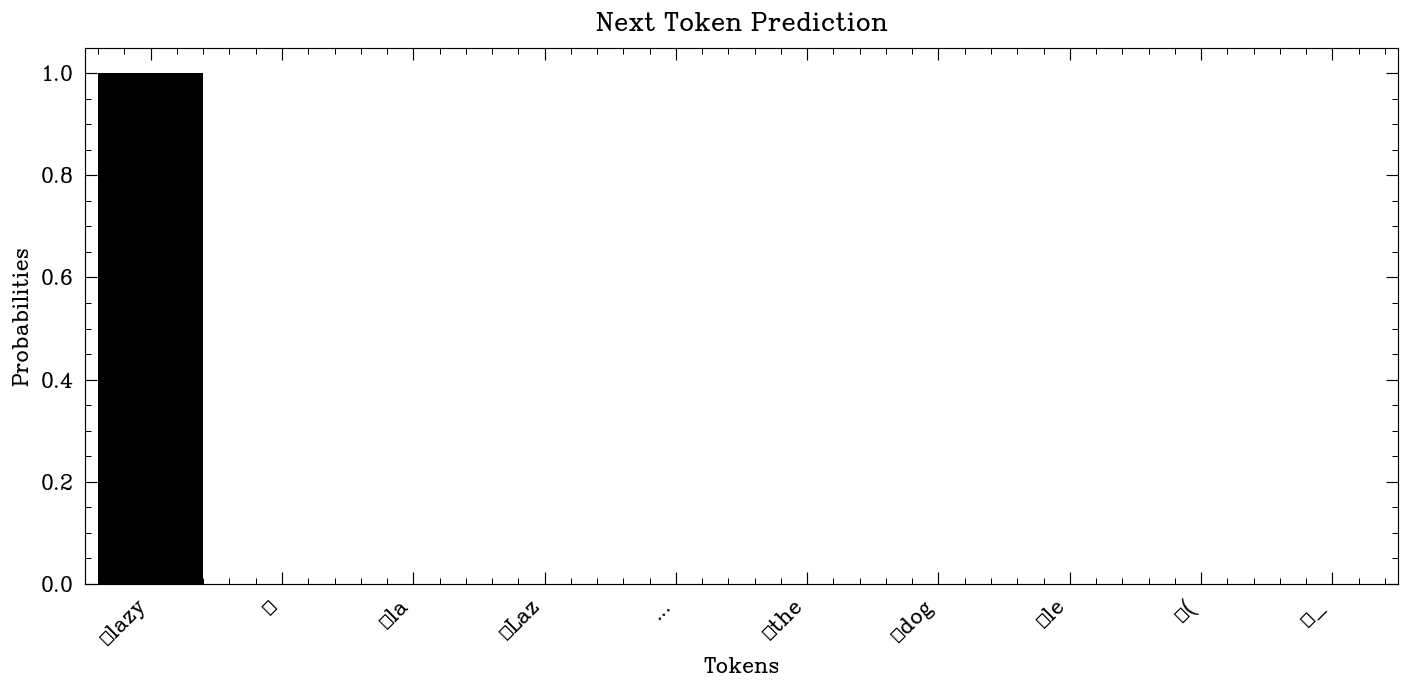

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def predict_next_token(model, tokenizer, sentence, top_k=10):
    model.eval()
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predictions = torch.softmax(logits[:, -1, :], dim=-1)
    top_k_probs, top_k_indices = torch.topk(predictions, top_k)

    top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_indices.squeeze().cpu().numpy())
    top_k_probs = top_k_probs.squeeze().cpu().numpy()

    return top_k_tokens, top_k_probs

def visualize_next_token_prediction(tokens, probs):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tokens, y=probs)
    plt.title('Next Token Prediction')
    plt.xlabel('Tokens')
    plt.ylabel('Probabilities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example sentence
sentence = "The quick brown fox jumps over the"

# Predict next token
tokens, probs = predict_next_token(model, tokenizer, sentence)

# Visualize next token prediction
visualize_next_token_prediction(tokens, probs)


In [38]:
import os
from PIL import Image

def generate_predictions_sequence(model, tokenizer, initial_sentence, num_predictions=5, top_k=10):
    sentences = [initial_sentence]
    current_sentence = initial_sentence

    for _ in range(num_predictions):
        tokens, probs = predict_next_token(model, tokenizer, current_sentence, top_k=top_k)
        next_token = tokens[np.argmax(probs)]
        current_sentence += ' ' + next_token
        sentences.append(current_sentence)

    return sentences

def save_visualizations_as_images(sentences, model, tokenizer, output_dir='visualizations', top_k=10):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, sentence in enumerate(sentences):
        tokens, probs = predict_next_token(model, tokenizer, sentence, top_k=top_k)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=tokens, y=probs)
        plt.title(f'Step {i+1}: "{sentence}"')
        plt.xlabel('Tokens')
        plt.ylabel('Probabilities')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'step_{i+1}.png'))
        plt.close()

# Example usage
initial_sentence = "The quick brown fox jumps over the"
num_predictions = 5

# Generate sequence of predictions
sentences = generate_predictions_sequence(model, tokenizer, initial_sentence, num_predictions=num_predictions)

# Save visualizations as images
save_visualizations_as_images(sentences, model, tokenizer)


In [45]:
import imageio

def create_gif_from_images(output_dir='visualizations', gif_filename='next_token_prediction.gif', duration=1):
    images = []
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith('.png'):
            file_path = os.path.join(output_dir, file_name)
            images.append(imageio.imread(file_path))

    imageio.mimsave(gif_filename, images, duration=duration)

# Create GIF from saved images
create_gif_from_images()


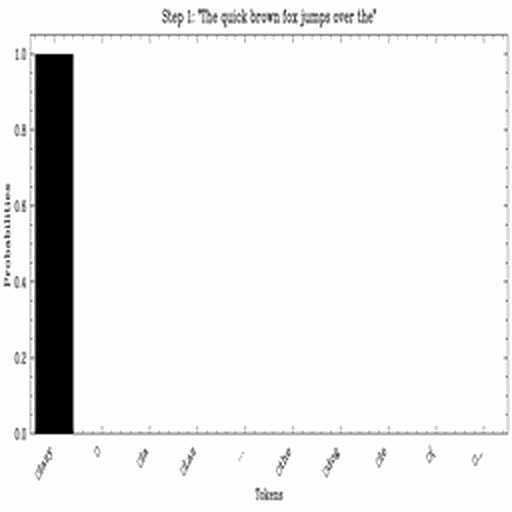

In [44]:
import os
import imageio
from PIL import Image as PILImage
from IPython.display import Image, display

def resize_image_to_square(image_path, size=512):
    with PILImage.open(image_path) as img:
        img = img.resize((size, size), PILImage.ANTIALIAS)
        img.save(image_path)

def create_gif_from_images(output_dir='visualizations', gif_filename='next_token_prediction.gif', duration=2):
    images = []

    # Resize images to square
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith('.png'):
            file_path = os.path.join(output_dir, file_name)
            resize_image_to_square(file_path, size=512)  # Resize to 256x256 pixels
            images.append(imageio.imread(file_path))

    imageio.mimsave(gif_filename, images, duration=duration, loop=0)  # loop=0 makes the GIF loop infinitely

# Example usage to create a slow, square GIF
create_gif_from_images()

# Display the GIF
display(Image(filename='next_token_prediction.gif'))


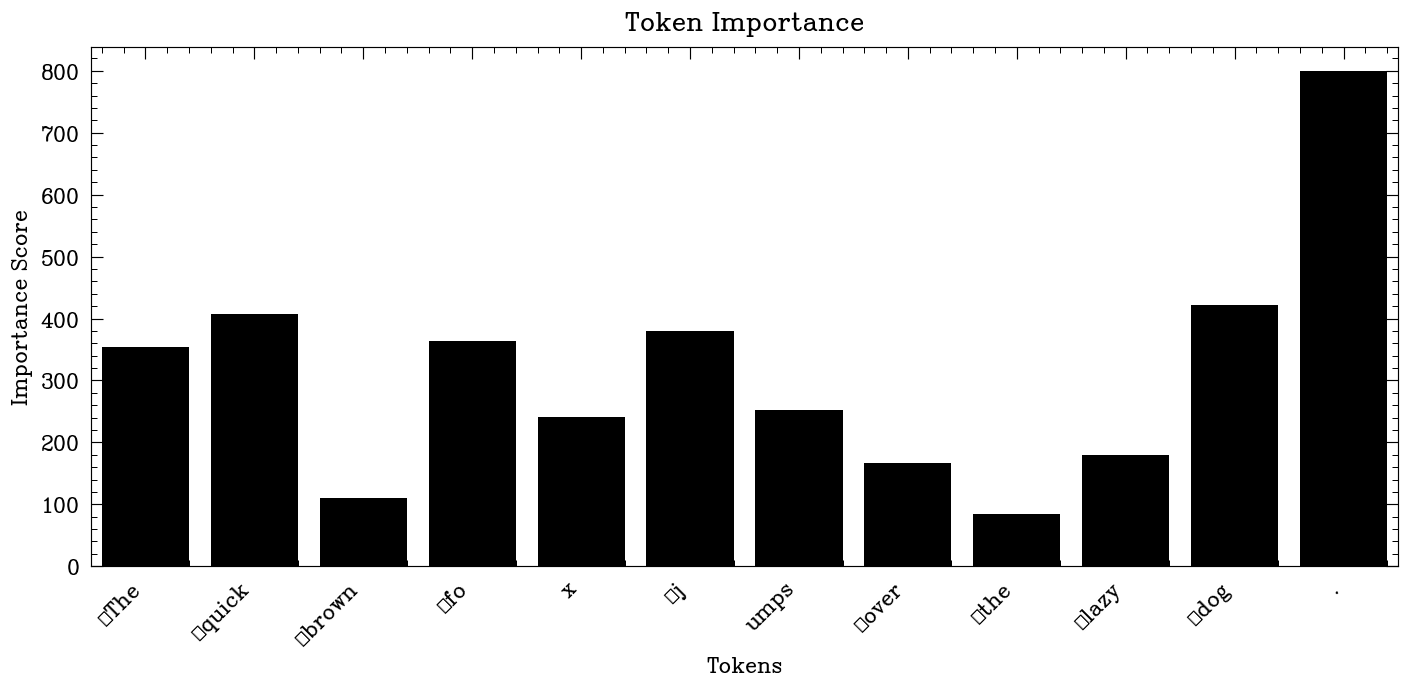

In [29]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def compute_token_importance(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        original_output = model(**inputs).logits

    importance_scores = []
    for i in range(inputs['input_ids'].shape[1]):
        # Remove the token instead of masking
        masked_input = inputs['input_ids'].clone()
        masked_input = torch.cat([masked_input[:, :i], masked_input[:, i+1:]], dim=1)

        with torch.no_grad():
            masked_output = model(masked_input).logits

        importance = torch.norm(original_output[:, -1] - masked_output[:, -1]).item()
        importance_scores.append(importance)

    return importance_scores

def visualize_token_importance(model, tokenizer, sentence):
    importance_scores = compute_token_importance(model, tokenizer, sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sentence))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=tokens, y=importance_scores)
    plt.title('Token Importance')
    plt.xlabel('Tokens')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

sentence = "The quick brown fox jumps over the lazy dog."
visualize_token_importance(model, tokenizer, sentence)

<a name="Data"></a>
### Data Prep
We now use the `Phi-3` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. Phi-3 renders multi turn conversations like below:

```
<s><|user|>
Hi!<|end|>
<|assistant|>
Hello! How are you?<|end|>
<|user|>
I'm doing great! And you?<|end|>

```

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old` and our own optimized `unsloth` template.

Note ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so we use `mapping` to map it.

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("philschmid/guanaco-sharegpt-style", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/9033 [00:00<?, ? examples/s]

Map:   0%|          | 0/9033 [00:00<?, ? examples/s]

Let's see how the `Phi-3` format works by printing the 5th element

In [ ]:
dataset[5]["conversations"]

[{'from': 'human',
  'value': 'What is the typical wattage of bulb in a lightbox?'},
 {'from': 'gpt',
  'value': 'The typical wattage of a bulb in a lightbox is 60 watts, although domestic LED bulbs are normally much lower than 60 watts, as they produce the same or greater lumens for less wattage than alternatives. A 60-watt Equivalent LED bulb can be calculated using the 7:1 ratio, which divides 60 watts by 7 to get roughly 9 watts.'},
 {'from': 'human',
  'value': 'Rewrite your description of the typical wattage of a bulb in a lightbox to only include the key points in a list format.'}]

In [ ]:
print(dataset[5]["text"])

<s><|user|>
What is the typical wattage of bulb in a lightbox?<|end|>
<|assistant|>
The typical wattage of a bulb in a lightbox is 60 watts, although domestic LED bulbs are normally much lower than 60 watts, as they produce the same or greater lumens for less wattage than alternatives. A 60-watt Equivalent LED bulb can be calculated using the 7:1 ratio, which divides 60 watts by 7 to get roughly 9 watts.<|end|>
<|user|>
Rewrite your description of the typical wattage of a bulb in a lightbox to only include the key points in a list format.<|end|>



If you're looking to make your own chat template, that also is possible! You must use the Jinja templating regime. We provide our own stripped down version of the `Unsloth template` which we find to be more efficient, and leverages ChatML, Zephyr and Alpaca styles.

More info on chat templates on [our wiki page!](https://github.com/unslothai/unsloth/wiki#chat-templates)

In [ ]:
unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # You must provide a template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/9033 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
2.283 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,033 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,2.037600
2,1.125900
3,1.475800
4,1.437900
5,1.376000
6,1.212100
7,0.897100
8,1.598800
9,1.534600
10,1.261300


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

495.8533 seconds used for training.
8.26 minutes used for training.
Peak reserved memory = 3.322 GB.
Peak reserved memory for training = 1.039 GB.
Peak reserved memory % of max memory = 22.525 %.
Peak reserved memory for training % of max memory = 7.045 %.


<a name="Inference"></a>
### Inference
Let's run the model! Since we're using `Phi-3`, use `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<s><|user|> Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|end|><|assistant|> 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, ']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<s><|user|> Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|end|><|assistant|> 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811,


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "What is a famous tall tower in Paris?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

<s><|user|> What is a famous tall tower in Paris?<|end|><|assistant|> The Eiffel Tower is a famous tall tower in Paris.<|end|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoModelForPeftCausalLM
    from transformers import AutoTokenizer
    model = AutoModelForPeftCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>